<a href="https://colab.research.google.com/github/dudaascariz/teste/blob/master/projeto_ML_predicao_porto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise exploratória de dados
Estimativa do horário de termino de operacão de navios de granel solido no Porto de Santos
Utilizaremos as bibliotecas pandas e numpy para fazer a manipulação dos dados.
Trabalharemos com a base de dados do Sistema SUPERVIA do Porto de Santos, que contém dados sobre atracação de navios e características de local, tipo de carga, horários de início e término de atracação e dimensões.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd

import datetime as dt
import numpy as np
import datetime
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from   sklearn.linear_model import LinearRegression
from   sklearn.metrics import r2_score
import statsmodels.api as sm
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_excel('/content/boletins_2016_2020.xlsx')

In [4]:
data.head()

,LOCAL_TERMINAL,LOCAL_ATRACACAO_X,LOCAL_ATRACACAO_DATA_INICIO,LOCAL_ATRACACAO_DATA_TERMINO,LOCAL_ATRACACAO_PROFUNDIDADE,NAVIO_IMO,NAVIO_CLASSE,NAVIO_CALADO,NAVIO_COMPRIMENTO,NAVIO_LARGURA,OPERADOR_NOME,CARGA_NATUREZA_X,QTDE_VIAGENS,QTDE_EMB_RAP,QTDE_DESC_RAP,EMBARQUE_TOTAL_T,DESCARGA_TOTAL_T,TOTAL_T,EMBARQUE_TOTAL_V,DESCARGA_TOTAL_V,TOTAL_V,EMBARQUE_TOTAL_CC_CV,DESCARGA_TOTAL_CC_CV,TOTAL_CC_CV
0,SAIPEM - TPF,918 - SAIPEM IV,2015-11-11 19:00:00,2016-01-08 10:00:00,0.0,9999195,EMBARCACAO DE APOIO,3.0,72,25.0,SERVNAV AGENCIAMENTOS E SERVIÇOS MARITIMOS LTDA,CG - CARGA GERAL SOLTA,1,100.0,100.0,788.0,NaN,788.0,14.0,NaN,14.0,NaN,NaN,NaN
1,SAIPEM - TPF,920 - SAIPEM II,2015-12-11 09:55:00,2016-01-24 10:00:00,0.0,9218234,CARGUEIRO COMUM,4.4,91,13.8,RELIANCE AGENCIAMENTO E SERVICOS PORTUARIOS LTDA.,CG - CARGA GERAL SOLTA,1,100.0,100.0,2154.0,NaN,2154.0,300.0,NaN,300.0,NaN,NaN,NaN
2,SAIPEM - TPF,919 - SAIPEM I,2015-12-21 08:30:00,2016-01-02 09:00:00,0.0,9340300,CARGUEIRO COMUM,4.4,90,13.8,RELIANCE AGENCIAMENTO E SERVICOS PORTUARIOS LTDA.,CC - CONTEINER CHEIO,1,1066.0,25.0,6.0,NaN,6.0,NaN,NaN,NaN,2.0,NaN,2.0
3,SAIPEM - TPF,919 - SAIPEM I,2015-12-21 08:30:00,2016-01-02 09:00:00,0.0,9340300,CARGUEIRO COMUM,4.4,90,13.8,RELIANCE AGENCIAMENTO E SERVICOS PORTUARIOS LTDA.,CG - CARGA GERAL SOLTA,1,1066.0,25.0,NaN,4.0,4.0,NaN,4.0,4.0,NaN,NaN,NaN
4,COREX - CPB,748 - ARMAZEM 38,2015-12-24 16:40:00,2016-01-05 02:15:00,13.7,9584592,GRANELEIRO,14.6,229,32.3,LOUIS DREYFUS COMMODITIES BRASIL S.A.,GS - GRANEL SOLIDO,1,58000.0,NaN,3879.0,NaN,3879.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41220 entries, 0 to 41219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOCAL_TERMINAL                41220 non-null  object        
 1   LOCAL_ATRACACAO_X             41220 non-null  object        
 2   LOCAL_ATRACACAO_DATA_INICIO   41032 non-null  datetime64[ns]
 3   LOCAL_ATRACACAO_DATA_TERMINO  41220 non-null  datetime64[ns]
 4   LOCAL_ATRACACAO_PROFUNDIDADE  41220 non-null  float64       
 5   NAVIO_IMO                     41220 non-null  int64         
 6   NAVIO_CLASSE                  41220 non-null  object        
 7   NAVIO_CALADO                  41220 non-null  float64       
 8   NAVIO_COMPRIMENTO             41220 non-null  int64         
 9   NAVIO_LARGURA                 41220 non-null  float64       
 10  OPERADOR_NOME                 41220 non-null  object        
 11  CARGA_NATUREZA_X            

### Tratamento de Dados Nulos nas colunas de data e total em toneladas

In [6]:
data = data[(data['LOCAL_ATRACACAO_DATA_INICIO'].notna()) & (data['LOCAL_ATRACACAO_DATA_TERMINO'].notna()) & (data['TOTAL_T'].notna()) ]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41016 entries, 0 to 41031
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOCAL_TERMINAL                41016 non-null  object        
 1   LOCAL_ATRACACAO_X             41016 non-null  object        
 2   LOCAL_ATRACACAO_DATA_INICIO   41016 non-null  datetime64[ns]
 3   LOCAL_ATRACACAO_DATA_TERMINO  41016 non-null  datetime64[ns]
 4   LOCAL_ATRACACAO_PROFUNDIDADE  41016 non-null  float64       
 5   NAVIO_IMO                     41016 non-null  int64         
 6   NAVIO_CLASSE                  41016 non-null  object        
 7   NAVIO_CALADO                  41016 non-null  float64       
 8   NAVIO_COMPRIMENTO             41016 non-null  int64         
 9   NAVIO_LARGURA                 41016 non-null  float64       
 10  OPERADOR_NOME                 41016 non-null  object        
 11  CARGA_NATUREZA_X            

### Criação de Coluna com o Tempo de Atracação, Conversão para horas e cálculo de taxa de operação (ton/h)

In [8]:
x= data.drop(columns=['OPERADOR_NOME','LOCAL_TERMINAL','NAVIO_IMO','QTDE_VIAGENS','QTDE_EMB_RAP', 'QTDE_DESC_RAP','QTDE_EMB_RAP','QTDE_DESC_RAP','EMBARQUE_TOTAL_V','DESCARGA_TOTAL_V','EMBARQUE_TOTAL_CC_CV','DESCARGA_TOTAL_CC_CV','TOTAL_CC_CV','EMBARQUE_TOTAL_T','EMBARQUE_TOTAL_V','DESCARGA_TOTAL_V','DESCARGA_TOTAL_T','TOTAL_V','DESCARGA_TOTAL_T','LOCAL_ATRACACAO_PROFUNDIDADE'])
x= x[(x['CARGA_NATUREZA_X'] == 'GS - GRANEL SOLIDO') ]
x

,LOCAL_ATRACACAO_X,LOCAL_ATRACACAO_DATA_INICIO,LOCAL_ATRACACAO_DATA_TERMINO,NAVIO_CLASSE,NAVIO_CALADO,NAVIO_COMPRIMENTO,NAVIO_LARGURA,CARGA_NATUREZA_X,TOTAL_T
4,748 - ARMAZEM 38,2015-12-24 16:40:00,2016-01-05 02:15:00,GRANELEIRO,14.6,229,32.3,GS - GRANEL SOLIDO,3879.0
5,627 - OUTEIRINHOS 2,2015-12-27 00:15:00,2016-01-04 13:35:00,GRANELEIRO,13.3,200,32.3,GS - GRANEL SOLIDO,5576.0
6,412 - ARMAZEM 12A,2015-12-27 23:15:00,2016-01-05 02:50:00,GRANELEIRO,14.9,229,38.0,GS - GRANEL SOLIDO,3450.0
7,419 - ARMAZEM 19,2015-12-29 13:35:00,2016-01-04 14:10:00,GRANELEIRO,13.4,190,32.3,GS - GRANEL SOLIDO,11750.0
8,803 - TGG,2015-12-29 21:30:00,2016-01-02 14:30:00,GRANELEIRO,14.4,225,32.2,GS - GRANEL SOLIDO,125.0
...,...,...,...,...,...,...,...,...,...
41017,901 - ULTRAFERTIL I,2020-12-30 20:50:00,2021-01-03 14:55:00,GRANELEIRO,13.3,200,32.3,GS - GRANEL SOLIDO,4297.0
41018,412 - ARMAZEM 12A,2020-12-30 22:10:00,2021-01-05 16:15:00,GRANELEIRO,13.0,196,32.2,GS - GRANEL SOLIDO,16029.0
41019,905 - ULTRAFERTIL IV,2020-12-30 22:45:00,2020-12-31 09:50:00,GRANELEIRO,12.9,200,32.3,GS - GRANEL SOLIDO,4524.0
41020,213 - SABOO III,2020-12-31 00:15:00,2021-01-07 23:20:00,GRANELEIRO,10.5,180,30.0,GS - GRANEL SOLIDO,1663.0


In [9]:
x['tempo_atracacao'] = x['LOCAL_ATRACACAO_DATA_TERMINO'] -x['LOCAL_ATRACACAO_DATA_INICIO']

In [10]:
x['tempo_atracacao_horas']=x['tempo_atracacao'] / np.timedelta64(1,'h')

In [11]:
x['taxa_tonh'] = x['TOTAL_T'] / x['tempo_atracacao_horas']

In [12]:
x = x[x.tempo_atracacao_horas != 0]

In [13]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8026 entries, 4 to 41026
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   LOCAL_ATRACACAO_X             8026 non-null   object         
 1   LOCAL_ATRACACAO_DATA_INICIO   8026 non-null   datetime64[ns] 
 2   LOCAL_ATRACACAO_DATA_TERMINO  8026 non-null   datetime64[ns] 
 3   NAVIO_CLASSE                  8026 non-null   object         
 4   NAVIO_CALADO                  8026 non-null   float64        
 5   NAVIO_COMPRIMENTO             8026 non-null   int64          
 6   NAVIO_LARGURA                 8026 non-null   float64        
 7   CARGA_NATUREZA_X              8026 non-null   object         
 8   TOTAL_T                       8026 non-null   float64        
 9   tempo_atracacao               8026 non-null   timedelta64[ns]
 10  tempo_atracacao_horas         8026 non-null   float64        
 11  taxa_tonh       

Qual é o atributo alvo?

In [16]:
y = x.taxa_tonh



#Caracterização de dados

In [17]:
x.dtypes


LOCAL_ATRACACAO_X                        object
LOCAL_ATRACACAO_DATA_INICIO      datetime64[ns]
LOCAL_ATRACACAO_DATA_TERMINO     datetime64[ns]
NAVIO_CLASSE                             object
NAVIO_CALADO                            float64
NAVIO_COMPRIMENTO                         int64
NAVIO_LARGURA                           float64
CARGA_NATUREZA_X                         object
TOTAL_T                                 float64
tempo_atracacao                 timedelta64[ns]
tempo_atracacao_horas                   float64
taxa_tonh                               float64
dtype: object

#Tipos de atributos

Qualitativos nominais

In [18]:
print('LOCAL_ATRACACAO_X', pd.unique(x.LOCAL_ATRACACAO_X))

LOCAL_ATRACACAO_X ['748 - ARMAZEM 38' '627 - OUTEIRINHOS 2' '412 - ARMAZEM 12A'
 '419 - ARMAZEM 19' '803 - TGG' '941 - TEAG' '416 - ARMAZEM 16/17'
 '759 - ARMAZEM 39' '420 - ARMAZEM 20/21' '942 - TEG' '422 - ARMAZEM 22'
 '804 - TERMAG' '413 - ARMAZEM13/14' '901 - ULTRAFERTIL I'
 '630 - ARMAZEM 29/30' '423 - ARMAZEM 23' '641 - ARMAZEM 31'
 '626 - OUTEIRINHOS 3' '652 - ARMAZEM 32' '931 - CUTRALE'
 '653 - ARMAZEM 33' '415 - ARMAZEM 15' '914 - USIMINAS IV'
 '525 - ARMAZEM 25' '111 - I. BARNABE SP' '903 - ULTRAFERTIL II'
 '640 - ARMAZEM 30' '524 - FRIGORIFICO' '904 - ULTRAFERTIL III'
 '310 - VALONGO' '905 - ULTRAFERTIL IV' '212 - SABOO II' '213 - SABOO III'
 '915 - USIMINAS V' '629 - ARMAZEM 29' '103 - ALAMOA III'
 '104 - ALAMOA IV' '112 - I. BARNABE BC' '102 - ALAMOA II' '910 - AGEO I'
 '665 - ARMAZEM 35' '211 - SABOO I']


In [19]:
print('NAVIO_CLASSE', pd.unique(x.NAVIO_CLASSE ))

NAVIO_CLASSE ['GRANELEIRO' 'CARGUEIRO COMUM' 'PETROLEIRO' 'PORTA-CONTAINERS'
 'GAS LIQUEFEITO' 'QUIMICO']


In [20]:
print('CARGA_NATUREZA_X', pd.unique(x.CARGA_NATUREZA_X))

CARGA_NATUREZA_X ['GS - GRANEL SOLIDO']


Quantitativo contínuo

In [21]:
print('NAVIO_CALADO', pd.unique(x.NAVIO_CALADO), '\n \n NAVIO_COMPRIMENTO', pd.unique(x.NAVIO_COMPRIMENTO), '\n \n NAVIO_LARGURA', pd.unique(x.NAVIO_LARGURA), '\n \n TOTAL_T', pd.unique(x.TOTAL_T), '\n \n PRODUTIVIDADE', pd.unique(x.taxa_tonh))

NAVIO_CALADO [  14.6   13.3   14.9   13.4   14.4   13.    12.5   14.2   12.9   14.
   14.1   12.8   10.    14.3   10.5    9.5   12.3    9.8   10.4   13.8
   36.1   14.7   12.7   14.5    9.7   12.6    9.    11.6   12.     8.5
   13.5   10.7   11.    11.8   10.1   10.6   10.9   12.2   10.2   11.3
   11.4   10.8   10.3   12.4    9.6   13.9   15.    11.9    9.9   12.1
   14.8   13.6   13.2   13.7   32.3    9.1   11.7   13.1    9.4    8.4
   19.5   18.    28.2    8.7   11.1   30.4    8.3   42.8   11.5    8.6
    1.5    0.     9.3   15.6    8.    20.5   18.6   20.1   18.7  105.
    9.2   18.5   23.3 1054. ] 
 
 NAVIO_COMPRIMENTO [229 200 190 225 177 180 181 183 179 210 230 240 169 224 198 140 170 189
 188 199 187 178 186 197 182 235 176 196 254 168 226 154 193 166 192 160
 165 155 260 216 237 185 191 171 201 158 172 213 175 206 132 157 151 223
 228 204 195 250 214 167 150 145 218 153 245 161 159 174 163 139 146 142
 234 144 202 264 217 141 120] 
 
 NAVIO_LARGURA [32.3 38.  32.2 36.8 32.  36.

##Escala intervalar 

LOCAL_ATRACACAO_DATA_INICIO      
LOCAL_ATRACACAO_DATA_TERMINO     

##Escala racional

NAVIO_CALADO                            
NAVIO_COMPRIMENTO                       
NAVIO_LARGURA                           
TOTAL_T                                

In [22]:
print(x.CARGA_NATUREZA_X.value_counts()) 


GS - GRANEL SOLIDO    8026
Name: CARGA_NATUREZA_X, dtype: int64


In [23]:
print(x.LOCAL_ATRACACAO_X.value_counts(),'\n \n', x.NAVIO_CLASSE.value_counts(),'\n \n', x.NAVIO_CALADO.value_counts())

416 - ARMAZEM 16/17      752
420 - ARMAZEM 20/21      679
803 - TGG                651
748 - ARMAZEM 38         646
419 - ARMAZEM 19         609
759 - ARMAZEM 39         432
901 - ULTRAFERTIL I      405
942 - TEG                397
804 - TERMAG             383
412 - ARMAZEM 12A        343
904 - ULTRAFERTIL III    338
941 - TEAG               314
903 - ULTRAFERTIL II     308
423 - ARMAZEM 23         269
413 - ARMAZEM13/14       234
626 - OUTEIRINHOS 3      202
931 - CUTRALE            149
630 - ARMAZEM 29/30      131
905 - ULTRAFERTIL IV     130
525 - ARMAZEM 25          84
653 - ARMAZEM 33          76
212 - SABOO II            76
422 - ARMAZEM 22          68
213 - SABOO III           66
415 - ARMAZEM 15          58
914 - USIMINAS IV         56
627 - OUTEIRINHOS 2       39
652 - ARMAZEM 32          22
112 - I. BARNABE BC       21
103 - ALAMOA III          18
111 - I. BARNABE SP       17
104 - ALAMOA IV           15
641 - ARMAZEM 31          12
524 - FRIGORIFICO          9
665 - ARMAZEM 

In [24]:
x.describe()

,NAVIO_CALADO,NAVIO_COMPRIMENTO,NAVIO_LARGURA,TOTAL_T,tempo_atracacao,tempo_atracacao_horas,taxa_tonh
count,8026.000000,8026.000000,8026.000000,8026.000000,8026,8026.000000,8026.000000
mean,13.101271,205.534513,31.649489,40064.920508,3 days 05:30:59.125342636,77.516424,674.101035
std,11.872397,20.981757,2.415438,21576.345893,2 days 11:01:59.377694033,59.033160,435.885903
min,0.000000,120.000000,0.000000,26.000000,0 days 05:45:00,5.750000,1.268293
25%,12.000000,190.000000,32.000000,21469.250000,1 days 17:20:00,41.333333,312.779762
50%,13.300000,200.000000,32.300000,36000.000000,2 days 16:20:00,64.333333,603.348931
75%,14.400000,229.000000,32.300000,62493.750000,4 days 01:00:00,97.000000,968.905497
max,1054.000000,264.000000,43.000000,102225.000000,94 days 05:30:00,2261.500000,2654.705882


In [25]:
print(x.tempo_atracacao_horas.max() - x.tempo_atracacao_horas.min())



2255.75


In [26]:
print(x.tempo_atracacao_horas.var())

3484.9140351434594


##Distribuição


In [27]:
print(x.tempo_atracacao_horas.skew())

8.004008413417134


In [28]:
print(x.tempo_atracacao_horas.kurtosis())

238.84536678176917


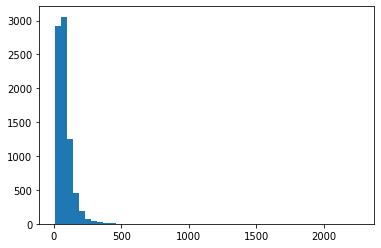

In [29]:
import matplotlib.pyplot as plt

plt.hist(x.tempo_atracacao_horas[~np.isnan(x.tempo_atracacao_horas)],50)
plt.show()

Text(0.5, 1.0, 'Matriz de Correlação')

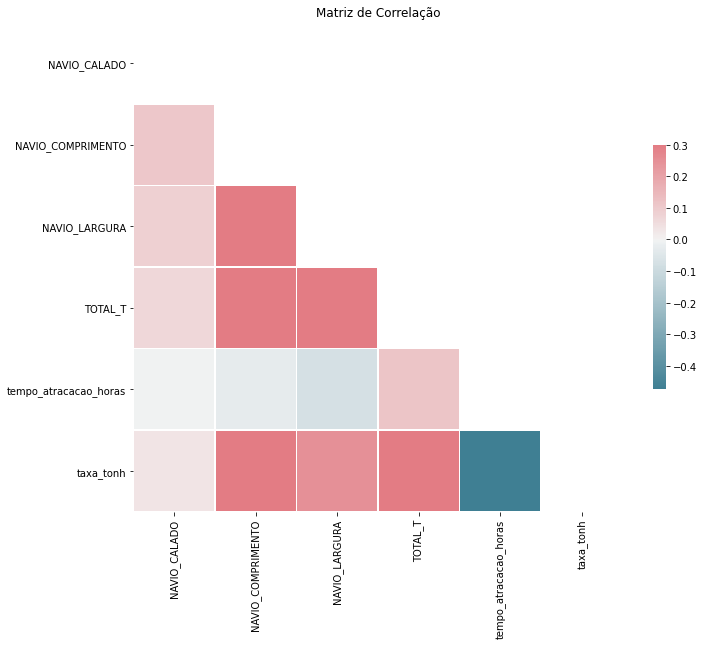

In [30]:
import seaborn as sns
corr = x.corr()

# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=np.bool)) 
# Set up the matplotlib figure 
f, ax = plt.subplots(figsize=(11, 9)) 
# Generate a custom diverging colormap 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
# Draw the heatmap with the mask and correct aspect ratio 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Matriz de Correlação')

In [31]:
x.columns

Index(['LOCAL_ATRACACAO_X', 'LOCAL_ATRACACAO_DATA_INICIO',
       'LOCAL_ATRACACAO_DATA_TERMINO', 'NAVIO_CLASSE', 'NAVIO_CALADO',
       'NAVIO_COMPRIMENTO', 'NAVIO_LARGURA', 'CARGA_NATUREZA_X', 'TOTAL_T',
       'tempo_atracacao', 'tempo_atracacao_horas', 'taxa_tonh'],
      dtype='object')

In [32]:
#excluindo outliers de tempo de atracacao
x= x[(x['tempo_atracacao_horas'] <= 600) ]
x

,LOCAL_ATRACACAO_X,LOCAL_ATRACACAO_DATA_INICIO,LOCAL_ATRACACAO_DATA_TERMINO,NAVIO_CLASSE,NAVIO_CALADO,NAVIO_COMPRIMENTO,NAVIO_LARGURA,CARGA_NATUREZA_X,TOTAL_T,tempo_atracacao,tempo_atracacao_horas,taxa_tonh
4,748 - ARMAZEM 38,2015-12-24 16:40:00,2016-01-05 02:15:00,GRANELEIRO,14.6,229,32.3,GS - GRANEL SOLIDO,3879.0,11 days 09:35:00,273.583333,14.178495
5,627 - OUTEIRINHOS 2,2015-12-27 00:15:00,2016-01-04 13:35:00,GRANELEIRO,13.3,200,32.3,GS - GRANEL SOLIDO,5576.0,8 days 13:20:00,205.333333,27.155844
6,412 - ARMAZEM 12A,2015-12-27 23:15:00,2016-01-05 02:50:00,GRANELEIRO,14.9,229,38.0,GS - GRANEL SOLIDO,3450.0,8 days 03:35:00,195.583333,17.639540
7,419 - ARMAZEM 19,2015-12-29 13:35:00,2016-01-04 14:10:00,GRANELEIRO,13.4,190,32.3,GS - GRANEL SOLIDO,11750.0,6 days 00:35:00,144.583333,81.268012
8,803 - TGG,2015-12-29 21:30:00,2016-01-02 14:30:00,GRANELEIRO,14.4,225,32.2,GS - GRANEL SOLIDO,125.0,3 days 17:00:00,89.000000,1.404494
...,...,...,...,...,...,...,...,...,...,...,...,...
41017,901 - ULTRAFERTIL I,2020-12-30 20:50:00,2021-01-03 14:55:00,GRANELEIRO,13.3,200,32.3,GS - GRANEL SOLIDO,4297.0,3 days 18:05:00,90.083333,47.700278
41018,412 - ARMAZEM 12A,2020-12-30 22:10:00,2021-01-05 16:15:00,GRANELEIRO,13.0,196,32.2,GS - GRANEL SOLIDO,16029.0,5 days 18:05:00,138.083333,116.082076
41019,905 - ULTRAFERTIL IV,2020-12-30 22:45:00,2020-12-31 09:50:00,GRANELEIRO,12.9,200,32.3,GS - GRANEL SOLIDO,4524.0,0 days 11:05:00,11.083333,408.180451
41020,213 - SABOO III,2020-12-31 00:15:00,2021-01-07 23:20:00,GRANELEIRO,10.5,180,30.0,GS - GRANEL SOLIDO,1663.0,7 days 23:05:00,191.083333,8.703009


In [33]:
#em razão correlação da taxa_tonh e navio_calado ser quase nula, optei por excluir essa coluna, also, como ja foi filtrado apenas GS - GRANEL SOLIDO, nao é mais necessario carga natureza
      #Filter: subsetting or removing observations based on some condition.
#Como já foi calculada a taxa_tonh não é mais necessária a tempo_atracação_horas
      # Transform: adding or modifying variables. These modifications can involve either a single variable (e.g., log-transformation), or multiple variables (e.g., computing density from weight and volume).
x= x.drop(columns=['NAVIO_CALADO','LOCAL_ATRACACAO_DATA_INICIO','LOCAL_ATRACACAO_DATA_TERMINO','tempo_atracacao','CARGA_NATUREZA_X','tempo_atracacao_horas'])


In [34]:
x.head()

,LOCAL_ATRACACAO_X,NAVIO_CLASSE,NAVIO_COMPRIMENTO,NAVIO_LARGURA,TOTAL_T,taxa_tonh
4,748 - ARMAZEM 38,GRANELEIRO,229,32.3,3879.0,14.178495
5,627 - OUTEIRINHOS 2,GRANELEIRO,200,32.3,5576.0,27.155844
6,412 - ARMAZEM 12A,GRANELEIRO,229,38.0,3450.0,17.639540
7,419 - ARMAZEM 19,GRANELEIRO,190,32.3,11750.0,81.268012
8,803 - TGG,GRANELEIRO,225,32.2,125.0,1.404494


In [35]:
print(x.LOCAL_ATRACACAO_X.value_counts())

416 - ARMAZEM 16/17      752
420 - ARMAZEM 20/21      679
803 - TGG                651
748 - ARMAZEM 38         646
419 - ARMAZEM 19         609
759 - ARMAZEM 39         432
901 - ULTRAFERTIL I      405
942 - TEG                397
804 - TERMAG             383
412 - ARMAZEM 12A        342
904 - ULTRAFERTIL III    338
941 - TEAG               314
903 - ULTRAFERTIL II     308
423 - ARMAZEM 23         269
413 - ARMAZEM13/14       234
626 - OUTEIRINHOS 3      202
931 - CUTRALE            149
630 - ARMAZEM 29/30      131
905 - ULTRAFERTIL IV     130
525 - ARMAZEM 25          84
653 - ARMAZEM 33          76
212 - SABOO II            76
422 - ARMAZEM 22          68
213 - SABOO III           66
415 - ARMAZEM 15          58
914 - USIMINAS IV         56
627 - OUTEIRINHOS 2       39
652 - ARMAZEM 32          22
112 - I. BARNABE BC       21
103 - ALAMOA III          18
111 - I. BARNABE SP       17
104 - ALAMOA IV           15
641 - ARMAZEM 31          12
524 - FRIGORIFICO          9
665 - ARMAZEM 

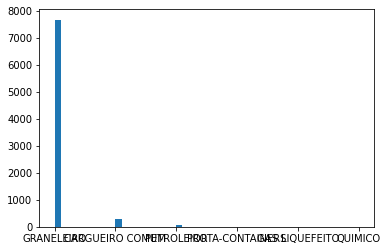

In [36]:
plt.hist(x.NAVIO_CLASSE,50)
plt.show()

In [37]:
#para fins de balanceamento e da maoir parte dos dados serem graneleiro, foi filtrado apenas navios desse tipo
x= x[(x['NAVIO_CLASSE'] == 'GRANELEIRO') ]
x= x.drop(columns=['NAVIO_CLASSE'])
x

,LOCAL_ATRACACAO_X,NAVIO_COMPRIMENTO,NAVIO_LARGURA,TOTAL_T,taxa_tonh
4,748 - ARMAZEM 38,229,32.3,3879.0,14.178495
5,627 - OUTEIRINHOS 2,200,32.3,5576.0,27.155844
6,412 - ARMAZEM 12A,229,38.0,3450.0,17.639540
7,419 - ARMAZEM 19,190,32.3,11750.0,81.268012
8,803 - TGG,225,32.2,125.0,1.404494
...,...,...,...,...,...
41017,901 - ULTRAFERTIL I,200,32.3,4297.0,47.700278
41018,412 - ARMAZEM 12A,196,32.2,16029.0,116.082076
41019,905 - ULTRAFERTIL IV,200,32.3,4524.0,408.180451
41020,213 - SABOO III,180,30.0,1663.0,8.703009


One hot encoding

In [38]:
#onehotencoding
xonehot= pd.get_dummies(x, prefix=['LOCAL_ATRACACAO_X'])

In [39]:
xonehot.head()


,NAVIO_COMPRIMENTO,NAVIO_LARGURA,TOTAL_T,taxa_tonh,LOCAL_ATRACACAO_X_211 - SABOO I,LOCAL_ATRACACAO_X_212 - SABOO II,LOCAL_ATRACACAO_X_213 - SABOO III,LOCAL_ATRACACAO_X_310 - VALONGO,LOCAL_ATRACACAO_X_412 - ARMAZEM 12A,LOCAL_ATRACACAO_X_413 - ARMAZEM13/14,LOCAL_ATRACACAO_X_415 - ARMAZEM 15,LOCAL_ATRACACAO_X_416 - ARMAZEM 16/17,LOCAL_ATRACACAO_X_419 - ARMAZEM 19,LOCAL_ATRACACAO_X_420 - ARMAZEM 20/21,LOCAL_ATRACACAO_X_422 - ARMAZEM 22,LOCAL_ATRACACAO_X_423 - ARMAZEM 23,LOCAL_ATRACACAO_X_525 - ARMAZEM 25,LOCAL_ATRACACAO_X_626 - OUTEIRINHOS 3,LOCAL_ATRACACAO_X_627 - OUTEIRINHOS 2,LOCAL_ATRACACAO_X_630 - ARMAZEM 29/30,LOCAL_ATRACACAO_X_640 - ARMAZEM 30,LOCAL_ATRACACAO_X_641 - ARMAZEM 31,LOCAL_ATRACACAO_X_652 - ARMAZEM 32,LOCAL_ATRACACAO_X_653 - ARMAZEM 33,LOCAL_ATRACACAO_X_665 - ARMAZEM 35,LOCAL_ATRACACAO_X_748 - ARMAZEM 38,LOCAL_ATRACACAO_X_759 - ARMAZEM 39,LOCAL_ATRACACAO_X_803 - TGG,LOCAL_ATRACACAO_X_804 - TERMAG,LOCAL_ATRACACAO_X_901 - ULTRAFERTIL I,LOCAL_ATRACACAO_X_903 - ULTRAFERTIL II,LOCAL_ATRACACAO_X_904 - ULTRAFERTIL III,LOCAL_ATRACACAO_X_905 - ULTRAFERTIL IV,LOCAL_ATRACACAO_X_914 - USIMINAS IV,LOCAL_ATRACACAO_X_915 - USIMINAS V,LOCAL_ATRACACAO_X_931 - CUTRALE,LOCAL_ATRACACAO_X_941 - TEAG,LOCAL_ATRACACAO_X_942 - TEG
4,229,32.3,3879.0,14.178495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,200,32.3,5576.0,27.155844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,229,38.0,3450.0,17.639540,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,190,32.3,11750.0,81.268012,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,225,32.2,125.0,1.404494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Normalização de dados

In [40]:
#normalizar dados
#https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

from sklearn.preprocessing import MinMaxScaler, StandardScaler
columns = ['NAVIO_COMPRIMENTO','NAVIO_LARGURA', 'TOTAL_T','taxa_tonh']
scaler = MinMaxScaler(feature_range=(0, 1))
xonehot[columns]= scaler.fit_transform(xonehot[columns])


In [41]:
 xonehot

,NAVIO_COMPRIMENTO,NAVIO_LARGURA,TOTAL_T,taxa_tonh,LOCAL_ATRACACAO_X_211 - SABOO I,LOCAL_ATRACACAO_X_212 - SABOO II,LOCAL_ATRACACAO_X_213 - SABOO III,LOCAL_ATRACACAO_X_310 - VALONGO,LOCAL_ATRACACAO_X_412 - ARMAZEM 12A,LOCAL_ATRACACAO_X_413 - ARMAZEM13/14,LOCAL_ATRACACAO_X_415 - ARMAZEM 15,LOCAL_ATRACACAO_X_416 - ARMAZEM 16/17,LOCAL_ATRACACAO_X_419 - ARMAZEM 19,LOCAL_ATRACACAO_X_420 - ARMAZEM 20/21,LOCAL_ATRACACAO_X_422 - ARMAZEM 22,LOCAL_ATRACACAO_X_423 - ARMAZEM 23,LOCAL_ATRACACAO_X_525 - ARMAZEM 25,LOCAL_ATRACACAO_X_626 - OUTEIRINHOS 3,LOCAL_ATRACACAO_X_627 - OUTEIRINHOS 2,LOCAL_ATRACACAO_X_630 - ARMAZEM 29/30,LOCAL_ATRACACAO_X_640 - ARMAZEM 30,LOCAL_ATRACACAO_X_641 - ARMAZEM 31,LOCAL_ATRACACAO_X_652 - ARMAZEM 32,LOCAL_ATRACACAO_X_653 - ARMAZEM 33,LOCAL_ATRACACAO_X_665 - ARMAZEM 35,LOCAL_ATRACACAO_X_748 - ARMAZEM 38,LOCAL_ATRACACAO_X_759 - ARMAZEM 39,LOCAL_ATRACACAO_X_803 - TGG,LOCAL_ATRACACAO_X_804 - TERMAG,LOCAL_ATRACACAO_X_901 - ULTRAFERTIL I,LOCAL_ATRACACAO_X_903 - ULTRAFERTIL II,LOCAL_ATRACACAO_X_904 - ULTRAFERTIL III,LOCAL_ATRACACAO_X_905 - ULTRAFERTIL IV,LOCAL_ATRACACAO_X_914 - USIMINAS IV,LOCAL_ATRACACAO_X_915 - USIMINAS V,LOCAL_ATRACACAO_X_931 - CUTRALE,LOCAL_ATRACACAO_X_941 - TEAG,LOCAL_ATRACACAO_X_942 - TEG
4,0.717742,0.751163,0.037701,0.004865,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.483871,0.751163,0.054306,0.009756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.717742,0.883721,0.033503,0.006170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.403226,0.751163,0.114717,0.030149,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.685484,0.748837,0.000969,0.000051,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0.483871,0.751163,0.041791,0.017499,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
41018,0.451613,0.748837,0.156587,0.043270,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41019,0.483871,0.751163,0.044012,0.153353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
41020,0.322581,0.697674,0.016018,0.002802,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
xonehot.to_csv(r'/content/dfpreprocessamento.csv')

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
xlr=xonehot.drop(['taxa_tonh'], axis=1)
y=xonehot['taxa_tonh']
xlr


,NAVIO_COMPRIMENTO,NAVIO_LARGURA,TOTAL_T,LOCAL_ATRACACAO_X_211 - SABOO I,LOCAL_ATRACACAO_X_212 - SABOO II,LOCAL_ATRACACAO_X_213 - SABOO III,LOCAL_ATRACACAO_X_310 - VALONGO,LOCAL_ATRACACAO_X_412 - ARMAZEM 12A,LOCAL_ATRACACAO_X_413 - ARMAZEM13/14,LOCAL_ATRACACAO_X_415 - ARMAZEM 15,LOCAL_ATRACACAO_X_416 - ARMAZEM 16/17,LOCAL_ATRACACAO_X_419 - ARMAZEM 19,LOCAL_ATRACACAO_X_420 - ARMAZEM 20/21,LOCAL_ATRACACAO_X_422 - ARMAZEM 22,LOCAL_ATRACACAO_X_423 - ARMAZEM 23,LOCAL_ATRACACAO_X_525 - ARMAZEM 25,LOCAL_ATRACACAO_X_626 - OUTEIRINHOS 3,LOCAL_ATRACACAO_X_627 - OUTEIRINHOS 2,LOCAL_ATRACACAO_X_630 - ARMAZEM 29/30,LOCAL_ATRACACAO_X_640 - ARMAZEM 30,LOCAL_ATRACACAO_X_641 - ARMAZEM 31,LOCAL_ATRACACAO_X_652 - ARMAZEM 32,LOCAL_ATRACACAO_X_653 - ARMAZEM 33,LOCAL_ATRACACAO_X_665 - ARMAZEM 35,LOCAL_ATRACACAO_X_748 - ARMAZEM 38,LOCAL_ATRACACAO_X_759 - ARMAZEM 39,LOCAL_ATRACACAO_X_803 - TGG,LOCAL_ATRACACAO_X_804 - TERMAG,LOCAL_ATRACACAO_X_901 - ULTRAFERTIL I,LOCAL_ATRACACAO_X_903 - ULTRAFERTIL II,LOCAL_ATRACACAO_X_904 - ULTRAFERTIL III,LOCAL_ATRACACAO_X_905 - ULTRAFERTIL IV,LOCAL_ATRACACAO_X_914 - USIMINAS IV,LOCAL_ATRACACAO_X_915 - USIMINAS V,LOCAL_ATRACACAO_X_931 - CUTRALE,LOCAL_ATRACACAO_X_941 - TEAG,LOCAL_ATRACACAO_X_942 - TEG
4,0.717742,0.751163,0.037701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.483871,0.751163,0.054306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.717742,0.883721,0.033503,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.403226,0.751163,0.114717,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.685484,0.748837,0.000969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0.483871,0.751163,0.041791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
41018,0.451613,0.748837,0.156587,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41019,0.483871,0.751163,0.044012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
41020,0.322581,0.697674,0.016018,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Split into training/testing sets

In [45]:
# Split into training/testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xlr, y)


In [46]:
#y_test.count()
y_test

3890     0.733753
22617    0.323988
19639    0.103073
40227    0.423957
7823     0.072788
           ...   
9176     0.066950
14368    0.384019
25371    0.187435
12468    0.305920
37649    0.199261
Name: taxa_tonh, Length: 1917, dtype: float64

#Regressão Linear

In [47]:
# Train the model using the training sets
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
#realizar predições
y_pred = reg.predict(x_test)
mean_squared_error(y_test, y_pred)

0.010504818855796703

In [49]:
# The coefficients
reg_score = r2_score(y_test, y_pred)
reg_score_train = reg.score(x_train, y_train)
reg_score_test = reg.score(x_test, y_test)
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      %  r2_score(y_test, y_pred))


Coefficients: 
 [-9.92497705e-02  9.47053215e-03  2.87672271e-01 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10 -9.48366951e+10
 -9.48366951e+10]
Mean squared error: 0.01
Coefficient of determination: 0.62


In [50]:
from sklearn.metrics import mean_absolute_error
mape_reg = mean_absolute_error(y_test, y_pred)*100
print(mape_reg)

7.784454324968079


In [52]:
from math import sqrt
rmse_reg = sqrt(mean_squared_error(y_test,y_pred))
print(rmse_reg)

0.1024930185710066


In [53]:
>>> reg.score(x_train, y_train)
0.7668160223286261
>>> reg.score(x_test, y_test)
0.6882607142538016

0.6882607142538016

#KNN

In [55]:
#https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
knn1 = KNeighborsRegressor(n_neighbors=3, p=2) # Euclidean

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    knn1 = neighbors.KNeighborsRegressor(n_neighbors = K)
    knn1.fit(x_train, y_train)  #fit the model
    pred=knn1.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.1328932056842713
RMSE value for k=  2 is: 0.11508976149319342
RMSE value for k=  3 is: 0.10831385706007152
RMSE value for k=  4 is: 0.10529886869296053
RMSE value for k=  5 is: 0.10356581622751912
RMSE value for k=  6 is: 0.10304861371088309
RMSE value for k=  7 is: 0.10168457603142557
RMSE value for k=  8 is: 0.10133067766606886
RMSE value for k=  9 is: 0.10099465764633185
RMSE value for k=  10 is: 0.10075089923964611
RMSE value for k=  11 is: 0.10093314579062822
RMSE value for k=  12 is: 0.10054321718098642
RMSE value for k=  13 is: 0.10021557853546069
RMSE value for k=  14 is: 0.0999911370568196
RMSE value for k=  15 is: 0.10031128325526896
RMSE value for k=  16 is: 0.10000669942524064
RMSE value for k=  17 is: 0.09990619836187688
RMSE value for k=  18 is: 0.09974966397522253
RMSE value for k=  19 is: 0.0996486018645835
RMSE value for k=  20 is: 0.09946842799019229


In [56]:
mape_knn = mean_absolute_error(y_test, pred)*100
print(mape_knn)

7.366973758045102


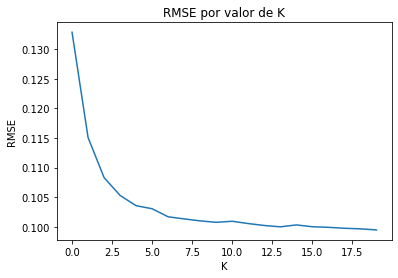

<Figure size 432x288 with 0 Axes>

In [57]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
plt.plot(curve)
plt.title('RMSE por valor de K')
plt.xlabel('K')   
plt.ylabel('RMSE') 
plt.show()
plt.savefig('rmse_kvalues.png', format='png')

In [58]:
#https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b
knn_score_train = knn1.score(x_train, y_train)
knn_score_test = knn1.score(x_test, pred)

#Árvore de regressão


In [59]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt


# create a regressor object
ad= DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
ad.fit(x_train, y_train)

# Predict
y_1 = ad.predict(x_test)

rmse_tree = sqrt(mean_squared_error(y_test,y_1)) #calculate rmse

In [60]:
error

0.09946842799019229

In [61]:
tree_score_train = ad.score(x_train, y_train)

In [62]:
tree_score_test = ad.score(x_test, y_test)

In [63]:
from sklearn.metrics import mean_absolute_error
mape_tree = mean_absolute_error(y_test, y_1)*100
print(mape_tree)

9.541492905671545


In [70]:
from tabulate import tabulate
resultados = [[ 'Linear Regression',rmse_reg , mape_reg, reg_score_train, reg_score_test],
['KNN', 0.09913309221801148, mape_knn, knn_score_train, knn_score_test],
['DecisionTree', rmse_tree, mape_tree, tree_score_train,tree_score_test]] 
print (tabulate(resultados, headers=["Modelo", "RMSE", "MAPE %", "Score Train", "Score test"]))

Modelo                  RMSE    MAPE %    Score Train    Score test
-----------------  ---------  --------  -------------  ------------
Linear Regression  0.102493    7.78445       0.610344       0.61655
KNN                0.0991331   7.36697       0.664312       1
DecisionTree       0.133849    9.54149       0.968376       0.34604
